In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product

from copy import deepcopy
from tqdm.notebook import tqdm
import ordpy
from scipy.stats import mode, ks_2samp

In [2]:
def runge_kutta(time_steps, y0, system, params):
    ys = [y0]
    for t in range(len(time_steps)-1):
        dt = time_steps[t+1]-time_steps[t]
        t0 = time_steps[t]
        t1 = time_steps[t+1]
        k1 = system(t0, y0, params)
        k2 = system(t0 + dt/2, y0 + dt / 2 * k1, params)
        k3 = system(t0 + dt/2, y0 + dt / 2 * k2, params)
        k4 = system(t1, y0 + dt * k3, params)
        y0  = y0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        ys.append(y0)
    return np.array(ys)

def lorentz_ode(t, xyz, params):
    x, y, z = xyz
    σ = params['σ']
    ρ = params['ρ']
    β = params['β']
    
    dx = σ * (y - x)
    dy = x * (ρ - z) - y
    dz = x * y - β * z
    
    return np.array([dx, dy, dz])

def get_data(p1 = 10., p2 = 28., p3 = 8/3):
    time_steps = np.arange(0, 1500, 0.1)
    params = {'σ' : p1, 'ρ' : p2, 'β' : p3}
    xyz0 = np.array([1., 1., 1.])
    lorenz_solution = runge_kutta(time_steps, xyz0, lorentz_ode, params)
    x, y, z = lorenz_solution[2000:].T

    x = (x - min(x)) / (max(x) - min(x))
    return x

In [3]:
params = (10., 28., 8/3)

x = get_data(*params)
points_number = x.shape[0]

In [4]:
# Hyper params
L = 4 # length of pattern
K = 10 # maximal value of pattern element

step = 50 # right shift value
M = 10 # iterations number

predicted_points_number = 50

In [5]:
# Builds matrix of patterns
z_vectors = np.array(list(product(np.arange(1, K + 1), repeat=L)))
patterns = np.cumsum(z_vectors, axis=1)
patterns = np.hstack([np.zeros((z_vectors.shape[0], 1)), patterns]).astype(int)

In [6]:
# Compute motives for train_data vector based on train_points number form point start

def fit(train_data, train_points_number, start, current_iter=1, max_iter=1):
    global patterns

    z_vectors_list = []
    for i in tqdm(range(patterns.shape[0]), desc=f"Computing matrix of Z-vectors, iteration {current_iter}/{max_iter}", leave=False):
        pattern = patterns[i]
        vecs = []
        for j in range(train_points_number - pattern[-1]):
            vecs.append(train_data[pattern + j + start])
        X = np.array(vecs)
        X[:] = (X[:] - X[:, :-1].min(axis=1, keepdims=True)) / (X[:, :-1].max(axis=1, keepdims=True) - X[:, :-1].min(axis=1, keepdims=True))
        z_vectors_list.append(X)
    return z_vectors_list

In [7]:
# Normalizing matrix

def norm(a):
    return np.sqrt(np.sum(np.square(a), axis=1))

In [8]:
# Predictions on train_data based on motives list by predicted_points_number points
# with max_dist between vectors and maximal allowed MAPE max_mape

def predict_with_demon(train_data, motives_list, begin, predicted_points_number, max_dist=0.05, max_mape=0.05):
  global patterns

  x_with_predictions = deepcopy(train_data) # copy of train_data with predictions
  for T in tqdm(range(begin, begin + predicted_points_number), desc="Demon predictions", leave=False):
      St = []
      # for i in tqdm(range(patterns.shape[0]), desc="Inner loop", leave=False):
      for i in range(patterns.shape[0]):
          vec = x_with_predictions[(patterns[i] + T - patterns[i][-1])[:-1]]
          mn, mx = min(vec), max(vec)
          if mx == np.inf:
             continue
          vec = (vec - mn) / (mx - mn)
          for motive in motives_list:
            normalized_predicted = norm(motive[i][:, :-1] - vec)
            St.extend(motive[i][(normalized_predicted < max_dist), :][:, -1] * (mx - mn) + mn)
      if len(St) == 0:
         predicted_value = np.inf
      else:
         predicted_value = mode(St, keepdims=True).mode[0]
         if abs(predicted_value - train_data[T]) / train_data[T] > max_mape:
            predicted_value = np.inf
      x_with_predictions[T] = predicted_value
  return x_with_predictions[begin : begin + predicted_points_number]

In [9]:
def calculate(train_points_number, begin):
    actual_vals_matrix = []
    predicted_vals_matrix = []
    
    motives_list = []

    for i in tqdm(range(M), "Overall iterations loop"):
        start = begin + step * i
        motives = fit(x, train_points_number, start, current_iter=i + 1, max_iter=M)
        motives_list.append(motives)

        actual_vals = x[start + train_points_number : start + train_points_number + predicted_points_number]
        predicted_vals = predict_with_demon(x, [motives], start + train_points_number, predicted_points_number)

        actual_vals_matrix.append(actual_vals)
        predicted_vals_matrix.append(predicted_vals)

    actual_vals_matrix = np.array(actual_vals_matrix)
    predicted_vals_matrix = np.array(predicted_vals_matrix)

    loss = np.zeros((predicted_points_number))
    unpredicted_points = np.zeros((predicted_points_number))

    for i in range(M):
        for j in range(predicted_points_number):
            if predicted_vals_matrix[i][j] == np.inf:
                unpredicted_points[j] += 1
            else:
                loss[j] += abs(predicted_vals_matrix[i][j] - actual_vals_matrix[i][j]) * 100 / actual_vals_matrix[i][j]
    loss /= M
    unpredicted_points /= M

    return actual_vals_matrix, predicted_vals_matrix, loss, unpredicted_points, motives_list

In [10]:
def calculate_mixed_1(train_points_number, begin, y_params):
    y = get_data(*y_params)
    actual_vals_matrix = []
    predicted_vals_matrix = []

    for i in tqdm(range(M), "Overall iterations loop"):
        start = begin + step * i
        x_motives = fit(x, train_points_number, start, current_iter=i + 1, max_iter=M)
        y_motives = fit(y, train_points_number, start, current_iter=i + 1, max_iter=M)

        motives_list = [x_motives, y_motives]

        actual_vals = x[start + train_points_number : start + train_points_number + predicted_points_number]
        predicted_vals = predict_with_demon(x, motives_list, start + train_points_number, predicted_points_number)

        actual_vals_matrix.append(actual_vals)
        predicted_vals_matrix.append(predicted_vals)

    actual_vals_matrix = np.array(actual_vals_matrix)
    predicted_vals_matrix = np.array(predicted_vals_matrix)

    loss = np.zeros((predicted_points_number))
    unpredicted_points = np.zeros((predicted_points_number))

    for i in range(M):
        for j in range(predicted_points_number):
            if predicted_vals_matrix[i][j] == np.inf:
                unpredicted_points[j] += 1
            else:
                loss[j] += abs(predicted_vals_matrix[i][j] - actual_vals_matrix[i][j]) * 100 / actual_vals_matrix[i][j]
    loss /= M
    unpredicted_points /= M

    return actual_vals_matrix, predicted_vals_matrix, loss, unpredicted_points

In [11]:
def calculate_mixed(train_points_number, begin, y_params):
    data = [x]
    for param in y_params:
        data.append(get_data(*param))

    actual_vals_matrix = []
    predicted_vals_matrix = []
    
    for i in tqdm(range(M), "Overall iterations loop"):
        start = begin + step * i

        motives_list = [fit(arr, train_points_number, start, current_iter=i + 1, max_iter=M) for arr in data]

        actual_vals = x[start + train_points_number : start + train_points_number + predicted_points_number]
        predicted_vals = predict_with_demon(x, motives_list, start + train_points_number, predicted_points_number)

        actual_vals_matrix.append(actual_vals)
        predicted_vals_matrix.append(predicted_vals)

    actual_vals_matrix = np.array(actual_vals_matrix)
    predicted_vals_matrix = np.array(predicted_vals_matrix)

    loss = np.zeros((predicted_points_number))
    unpredicted_points = np.zeros((predicted_points_number))

    for i in range(M):
        for j in range(predicted_points_number):
            if predicted_vals_matrix[i][j] == np.inf:
                unpredicted_points[j] += 1
            else:
                loss[j] += abs(predicted_vals_matrix[i][j] - actual_vals_matrix[i][j]) * 100 / actual_vals_matrix[i][j]
    loss /= M
    unpredicted_points /= M

    return actual_vals_matrix, predicted_vals_matrix, loss, unpredicted_points

In [12]:
def plots(train_points_number, loss, unpredicted_points):
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(f"Trained on original series with local normalization, train_size={train_points_number}")

    plt.subplot(1, 2, 1)
    plt.title("MAPE, %")
    plt.plot(loss)

    plt.subplot(1, 2, 2)
    plt.ylim((-0.1, 1.1))
    plt.title("Unpredicted points")
    plt.plot(unpredicted_points)

    plt.show()

In [13]:
train_points_number = 1000
begin = 0

In [18]:
def metrics(params):
    y = get_data(*params)
    c = []
    e = []
    for _ in range(M):
        cc, ee = ordpy.complexity_entropy(y, dx=5)
        c.append(cc)
        e.append(ee)
    colm = np.mean([ks_2samp(x[begin + step * j: begin + step * j + train_points_number], y[begin + step * j: begin + step * j + train_points_number])[0] for j in range(M)])
    return np.mean(np.array(c)), np.mean(np.array(e)), colm

In [ ]:
data0 = calculate(train_points_number, begin)

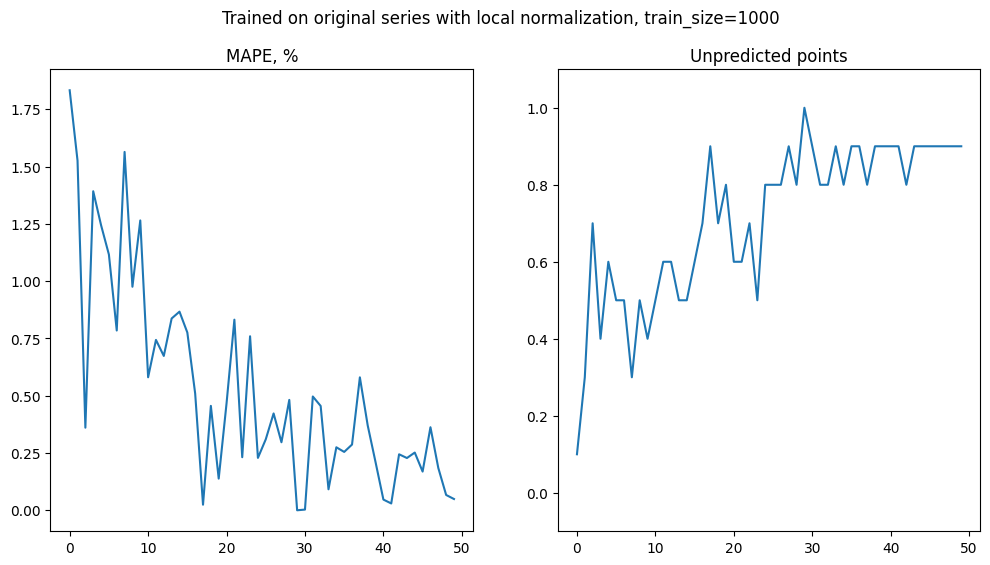

In [ ]:
plots(train_points_number, data0[2], data0[3])

In [ ]:
print(np.mean(data0[3]))

0.7140000000000001


Mixing 1

In [ ]:
params1 = (params[0] * 0.99, params[1], params[2])
data1 = calculate_mixed_1(train_points_number, begin, params1)

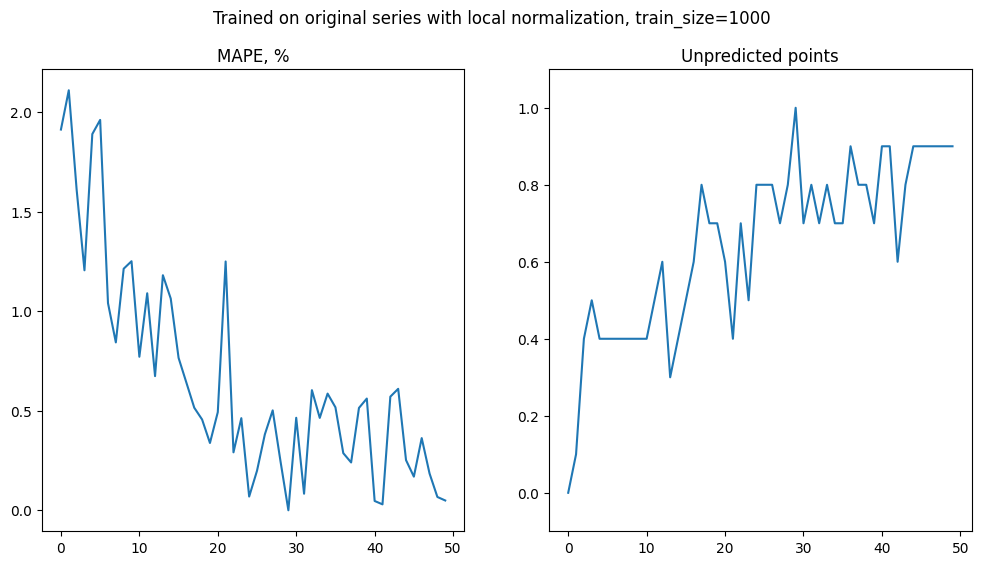

In [ ]:
plots(train_points_number, data1[2], data1[3])

In [ ]:
print(np.mean(data1[3]))

0.6439999999999999


Mixing 2

In [ ]:
mat2 = np.array([
    [0.99, 1., 1.],
    [1., 1.01, 1.]
])
data2 = calculate_mixed(train_points_number, begin, mat2 * params)

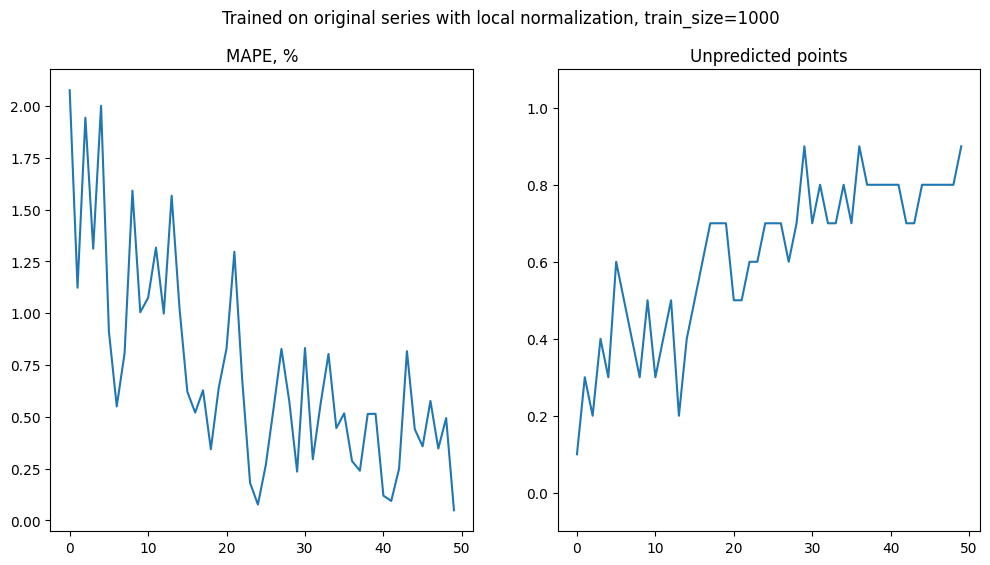

In [20]:
plots(train_points_number, data2[2], data2[3])

In [21]:
print(np.mean(data2[3]))

0.614


Mixing 3

In [ ]:
params3 = (params[0] * 1., params[1] * 1.01, params[2] * 1.)
data3 = calculate_mixed_1(train_points_number, begin, params3)

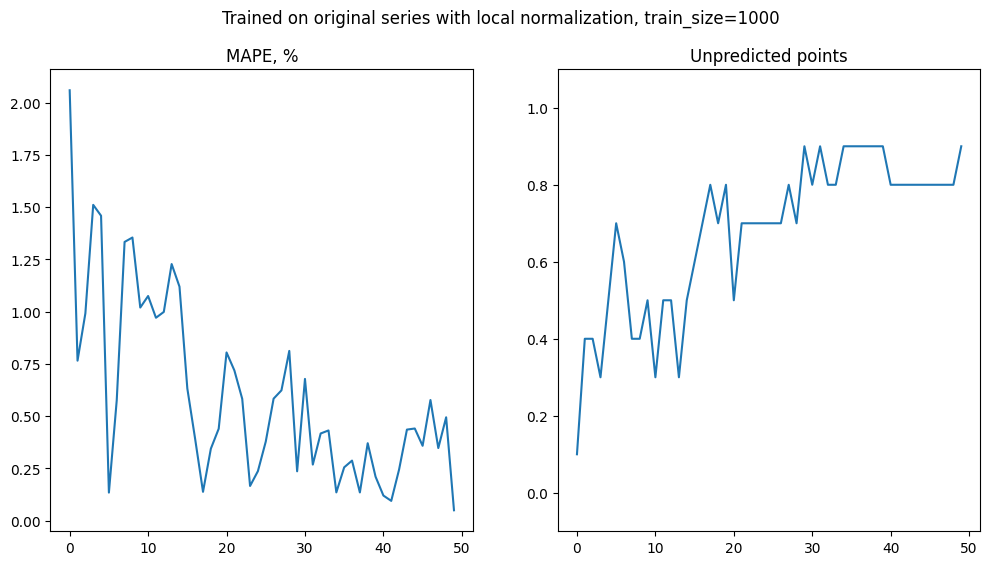

In [26]:
plots(train_points_number, data3[2], data3[3])

In [27]:
print(np.mean(data3[3]))

0.6779999999999998


Mixing 4

In [ ]:
mat4 = np.array([
    [0.99, 1., 1.],
    [1., 1.01, 1.],
    [1., 1., 0.98]
])
data4 = calculate_mixed(train_points_number, begin, mat4 * params)

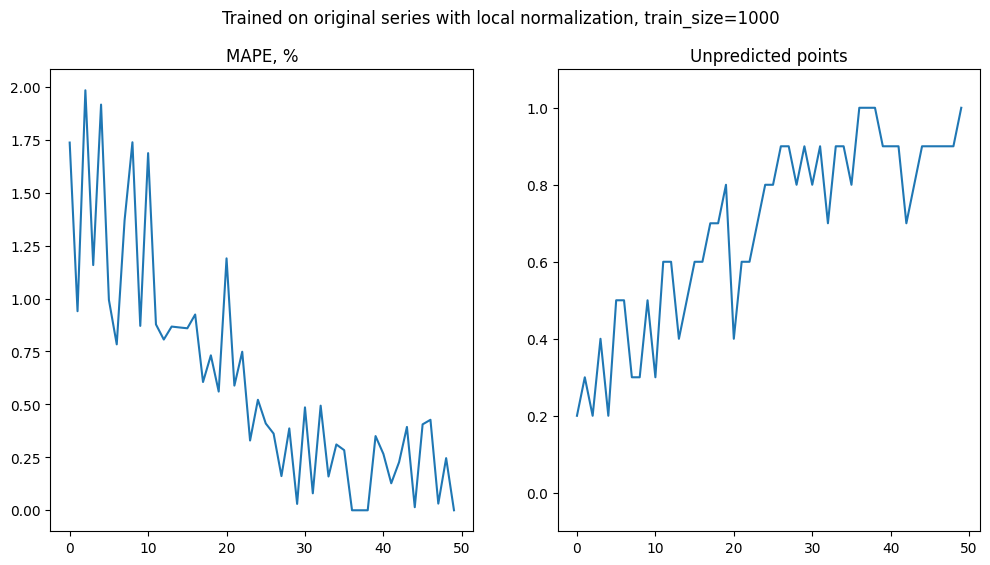

In [19]:
plots(train_points_number, data4[2], data4[3])

In [20]:
print(np.mean(data4[3]))

0.6859999999999999


Mixing 5

In [ ]:
mat5 = np.array([
    [0.99, 1., 1.],
    [1., 1.01, 1.],
    [1., 1., 0.98],
    [0.98, 1.01, 0.99]
])
data5 = calculate_mixed(train_points_number, begin, mat5 * params)

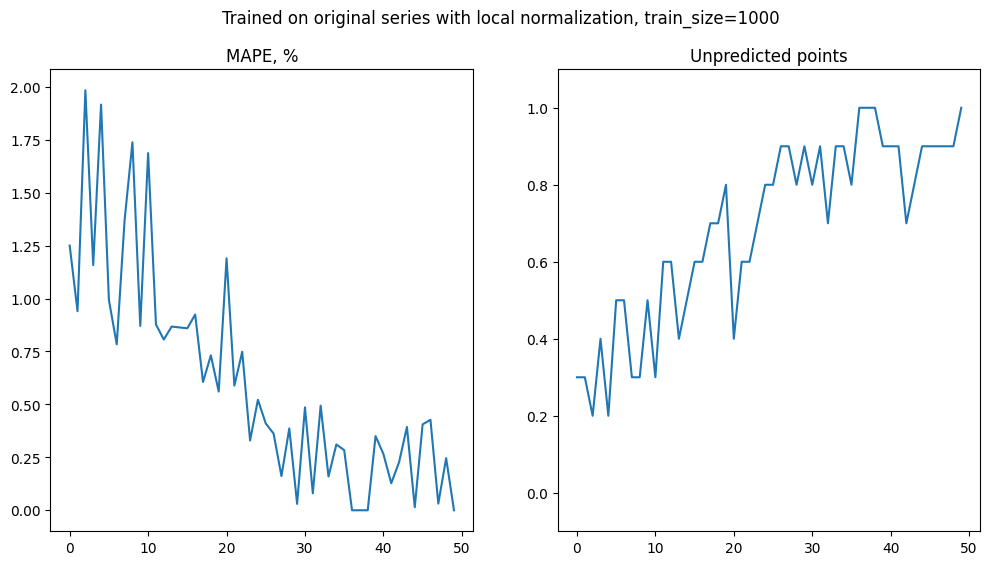

In [22]:
plots(train_points_number, data5[2], data5[3])

In [23]:
print(np.mean(data5[3]))

0.688


In [ ]:
s = []

for p1 in tqdm(np.linspace(0.98, 1.02, 5), desc="Loop"):
    for p2 in np.linspace(0.98, 1.02, 5):
        for p3 in np.linspace(0.98, 1.02, 5):
            colm = np.mean([ks_2samp(x[begin + step * j: begin + step * j + train_points_number], get_data(params[0] * p1, params[1] * p2, params[2] * p3)[begin + step * j: begin + step * j + train_points_number])[0] for j in range(M)])
            s.append([colm, p1, p2, p3])

In [38]:
ss = sorted(s)

In [39]:
print(*ss[:10], sep='\n')

[np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
[np.float64(0.029300000000000003), np.float64(1.01), np.float64(1.01), np.float64(1.02)]
[np.float64(0.029400000000000003), np.float64(0.99), np.float64(0.99), np.float64(1.02)]
[np.float64(0.0316), np.float64(1.01), np.float64(0.99), np.float64(1.0)]
[np.float64(0.03230000000000001), np.float64(1.02), np.float64(1.01), np.float64(0.99)]
[np.float64(0.0388), np.float64(0.99), np.float64(1.0), np.float64(0.98)]
[np.float64(0.0409), np.float64(1.02), np.float64(1.0), np.float64(0.98)]
[np.float64(0.041100000000000005), np.float64(1.0), np.float64(1.0), np.float64(0.99)]
[np.float64(0.0412), np.float64(0.99), np.float64(0.98), np.float64(0.99)]
[np.float64(0.042100000000000005), np.float64(0.99), np.float64(0.98), np.float64(1.01)]


In [40]:
print(*ss[-10:], sep='\n')

[np.float64(0.13040000000000002), np.float64(1.0), np.float64(0.98), np.float64(1.02)]
[np.float64(0.13190000000000002), np.float64(1.02), np.float64(1.0), np.float64(1.0)]
[np.float64(0.13790000000000002), np.float64(0.99), np.float64(0.99), np.float64(0.99)]
[np.float64(0.1382), np.float64(0.98), np.float64(1.01), np.float64(1.02)]
[np.float64(0.1455), np.float64(0.98), np.float64(1.02), np.float64(0.99)]
[np.float64(0.14800000000000002), np.float64(0.99), np.float64(1.01), np.float64(1.01)]
[np.float64(0.1514), np.float64(1.0), np.float64(0.99), np.float64(1.0)]
[np.float64(0.161), np.float64(0.98), np.float64(1.0), np.float64(1.0)]
[np.float64(0.1896), np.float64(1.02), np.float64(1.02), np.float64(1.01)]
[np.float64(0.20340000000000003), np.float64(1.01), np.float64(1.02), np.float64(1.02)]


Mixing 6 (closest)

In [ ]:
params6 = (params[0] * 1.01, params[1] * 1.01, params[2] * 1.02)
data6 = calculate_mixed_1(train_points_number, begin, params6)

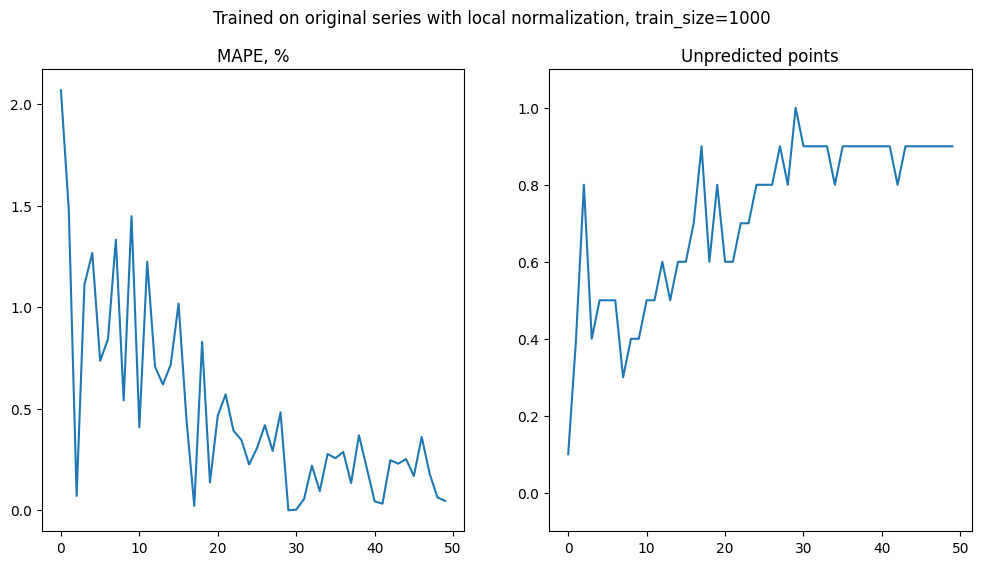

In [43]:
plots(train_points_number, data6[2], data6[3])

In [44]:
print(np.mean(data6[3]))

0.7219999999999999


Mixing 7 (furtherest)

In [ ]:
params7 = (params[0] * 1.01, params[1] * 1.02, params[2] * 1.02)
data7 = calculate_mixed_1(train_points_number, begin, params7)

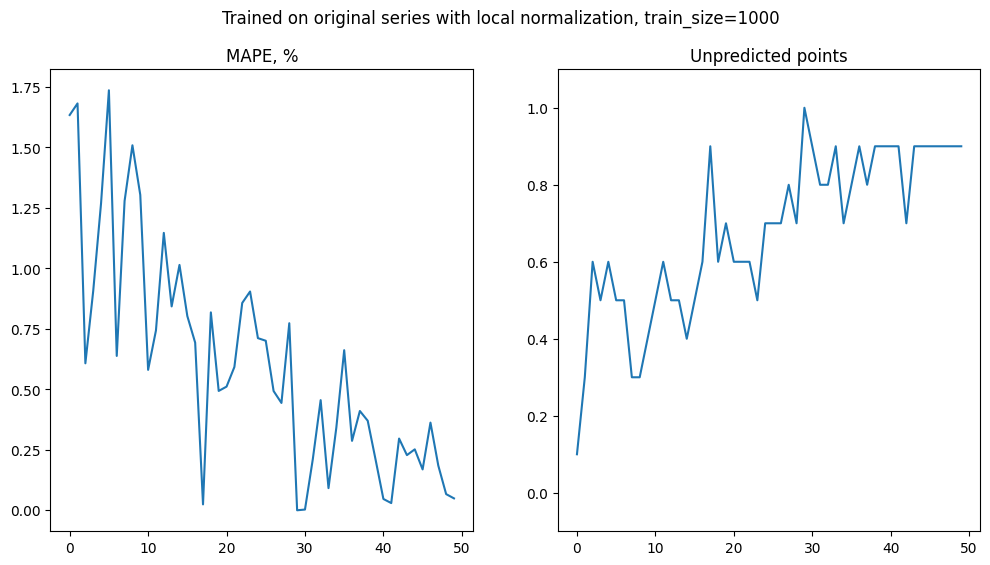

In [46]:
plots(train_points_number, data7[2], data7[3])

In [47]:
print(np.mean(data7[3]))

0.68


Mixing 8 (4 closest)

In [ ]:
mat8 = np.array([
    [1.01, 1.01, 1.02],
    [0.99, 0.99, 1.02],
    [1.01, 0.99, 1.],
    [1.02, 1.01, 0.99]
])
data8 = calculate_mixed(train_points_number, begin, mat8 * params)

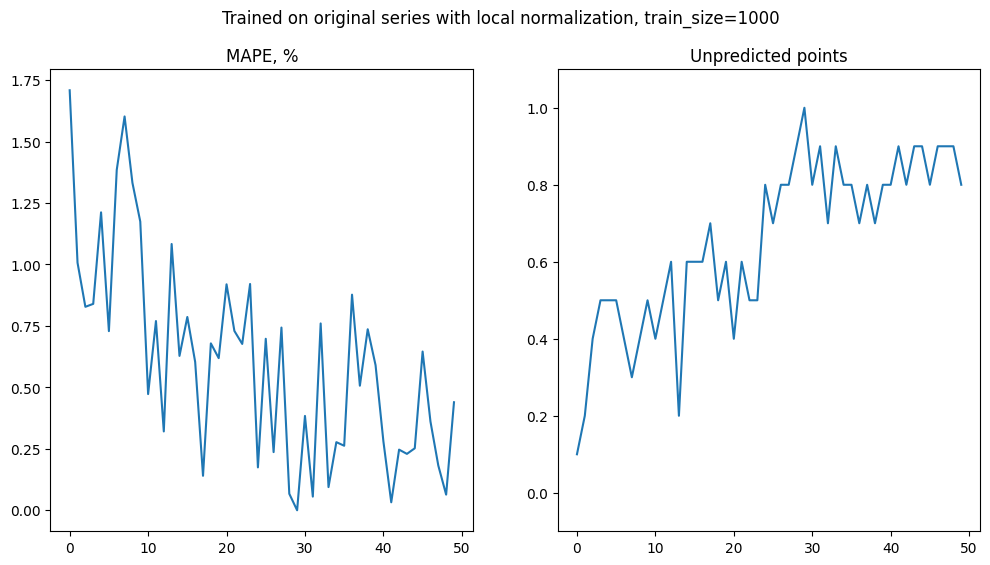

In [61]:
plots(train_points_number, data8[2], data8[3])

In [62]:
print(np.mean(data8[3]))

0.6519999999999999


Mixing 9 (4 furtherest)

In [ ]:
mat9 = np.array([
    [1., 0.99, 1.],
    [0.98, 1., 1.],
    [1.02, 1.02, 1.01],
    [1.01, 1.02, 1.02]
])
data9 = calculate_mixed(train_points_number, begin, mat9 * params)

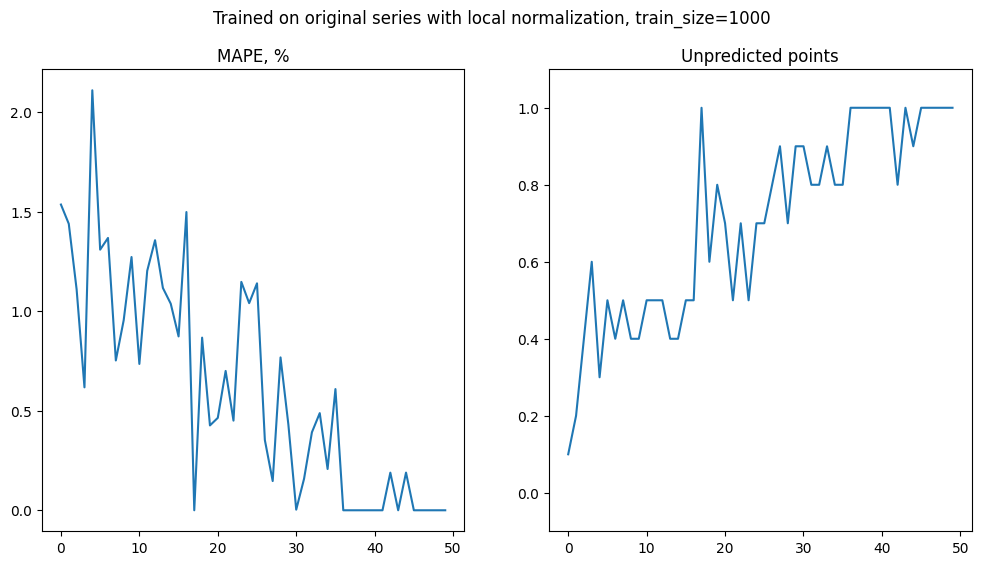

In [16]:
plots(train_points_number, data9[2], data9[3])

In [17]:
print(np.mean(data9[3]))

0.706


Mixing 10

In [ ]:
params10 = (params[0] * 0.99, params[1] * 0.99, params[2] * 1.02)
data10 = calculate_mixed_1(train_points_number, begin, params10)

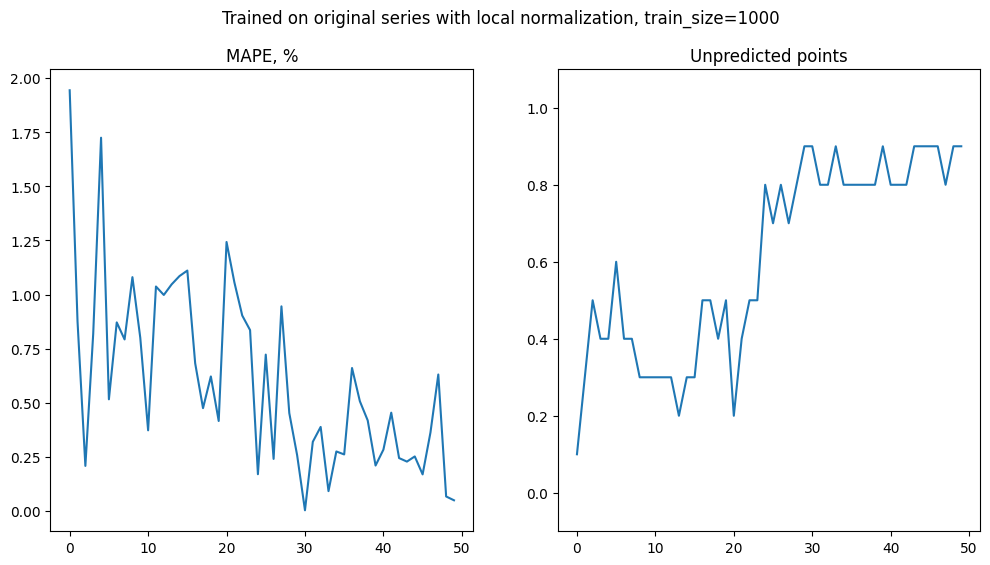

In [21]:
plots(train_points_number, data10[2], data10[3])

In [22]:
print(np.mean(data10[3]))

0.6099999999999999


Mixing 11

In [ ]:
params11 = (params[0] * 1.01, params[1] * 0.99, params[2])
data11 = calculate_mixed_1(train_points_number, begin, params11)

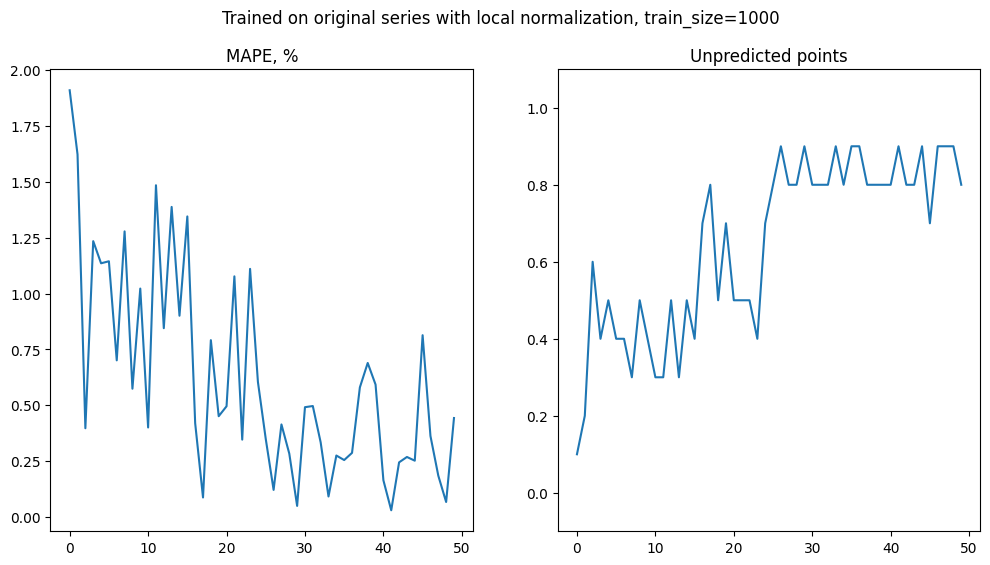

In [24]:
plots(train_points_number, data11[2], data11[3])

In [25]:
print(np.mean(data11[3]))

0.6459999999999999


Mixing 12

In [ ]:
params12 = (params[0] * 1.02, params[1] * 1.01, params[2] * 0.99)
data12 = calculate_mixed_1(train_points_number, begin, params12)

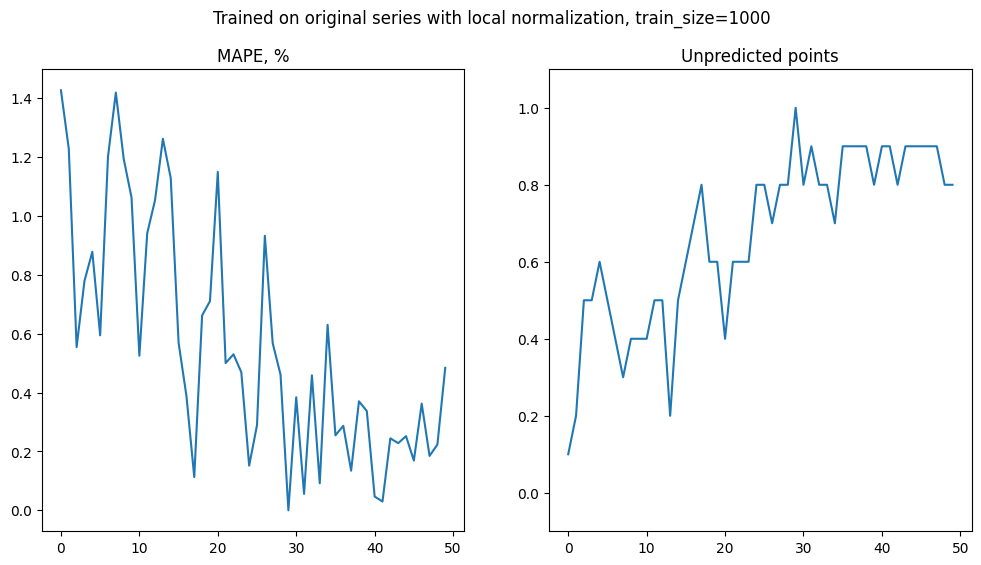

In [27]:
plots(train_points_number, data12[2], data12[3])

In [28]:
print(np.mean(data12[3]))

0.6699999999999998


Mixing 13

In [ ]:
params13 = (params[0] * 0.99, params[1], params[2] * 0.98)
data13 = calculate_mixed_1(train_points_number, begin, params13)

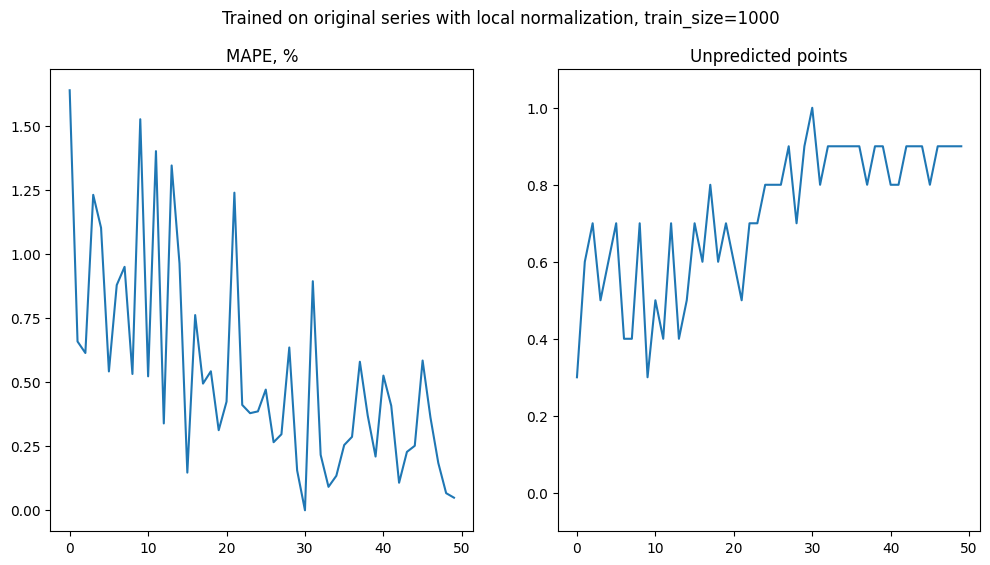

In [30]:
plots(train_points_number, data13[2], data13[3])

In [31]:
print(np.mean(data13[3]))

0.7219999999999999


In [36]:
y13 = get_data(*params13)
s = 0
for i in range(10):
    s += ks_2samp(x[50 * i:1000 + 50 * i], y13[50 * i:1000 + 50 * i])[0]
print(s / 10)

0.0388


Mixing 14

In [ ]:
mat14 = np.array([
    [0.99, 0.99, 1.02],
    [1.01, 0.99, 1.]
])
data14 = calculate_mixed(train_points_number, begin, mat14 * params)

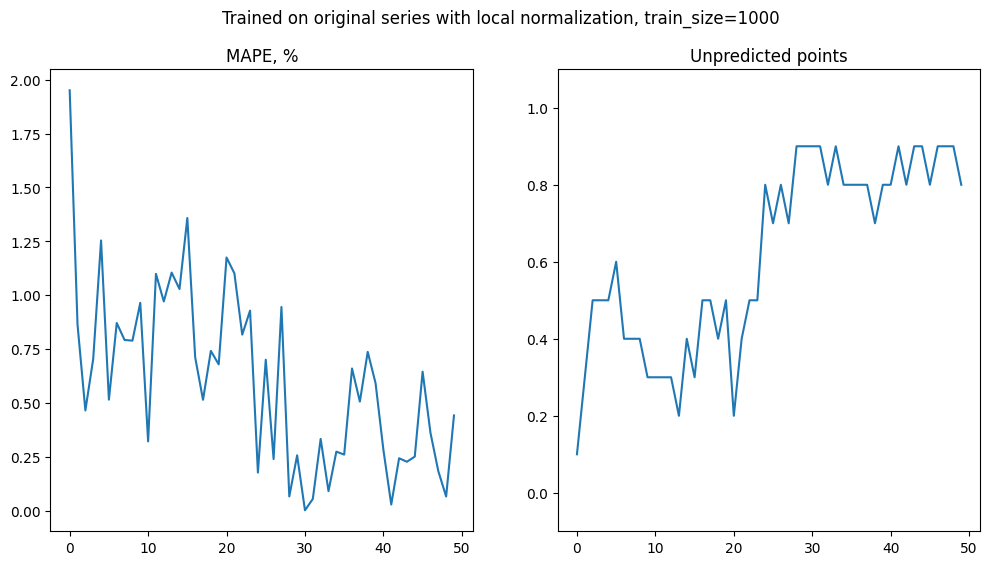

In [39]:
plots(train_points_number, data14[2], data14[3])

In [40]:
print(np.mean(data14[3]))

0.618


Mixing 15

In [ ]:
mat15 = np.array([
    [0.99, 0.99, 1.02],
    [1.01, 0.99, 1.],
    [0.99, 1., 1.]
])
data15 = calculate_mixed(train_points_number, begin, mat15 * params)

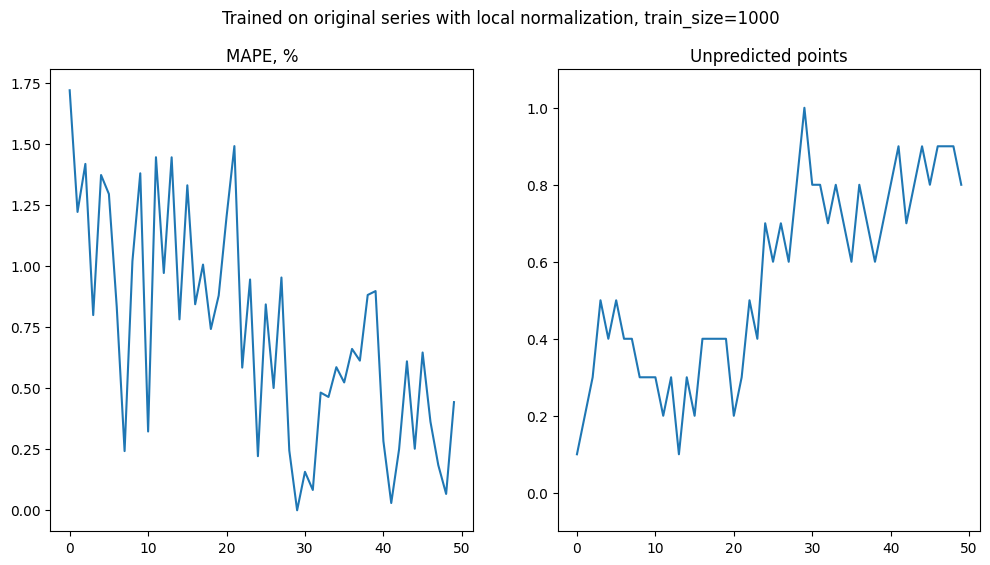

In [42]:
plots(train_points_number, data15[2], data15[3])

In [43]:
print(np.mean(data15[3]))

0.5559999999999999


Mixing 16

In [ ]:
mat16 = np.array([
    [0.99, 0.99, 1.02],
    [1.01, 0.99, 1.],
    [1.01, 1.01, 1.02]
])
data16 = calculate_mixed(train_points_number, begin, mat16 * params)

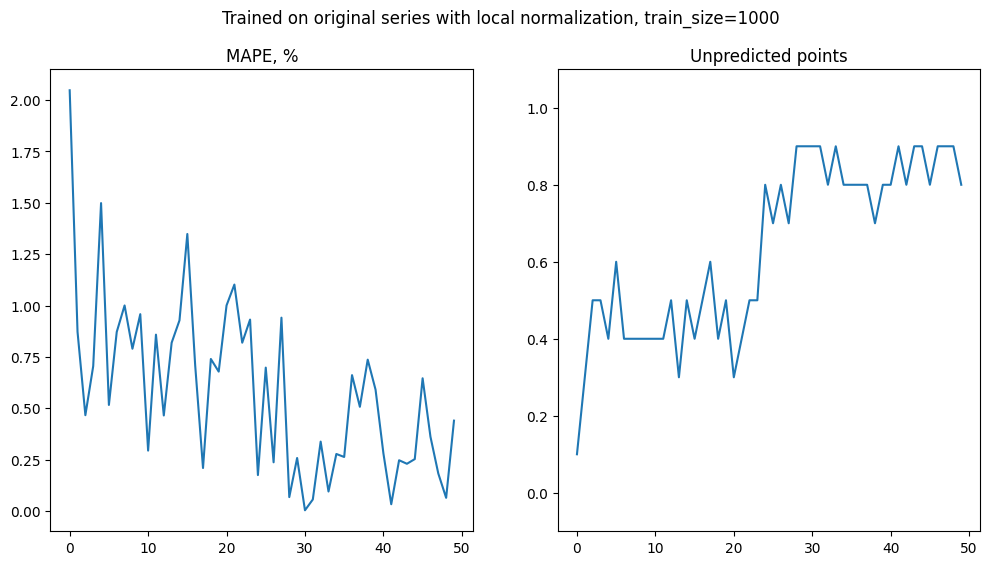

In [48]:
plots(train_points_number, data16[2], data16[3])

In [49]:
print(np.mean(data16[3]))

0.6359999999999999


Mixing 17

In [ ]:
mat17 = np.array([
    [0.99, 0.99, 1.02],
    [1.01, 0.99, 1.],
    [0.99, 1., 1.],
    [1.02, 1.01, 0.99]
])
data17 = calculate_mixed(train_points_number, begin, mat17 * params)

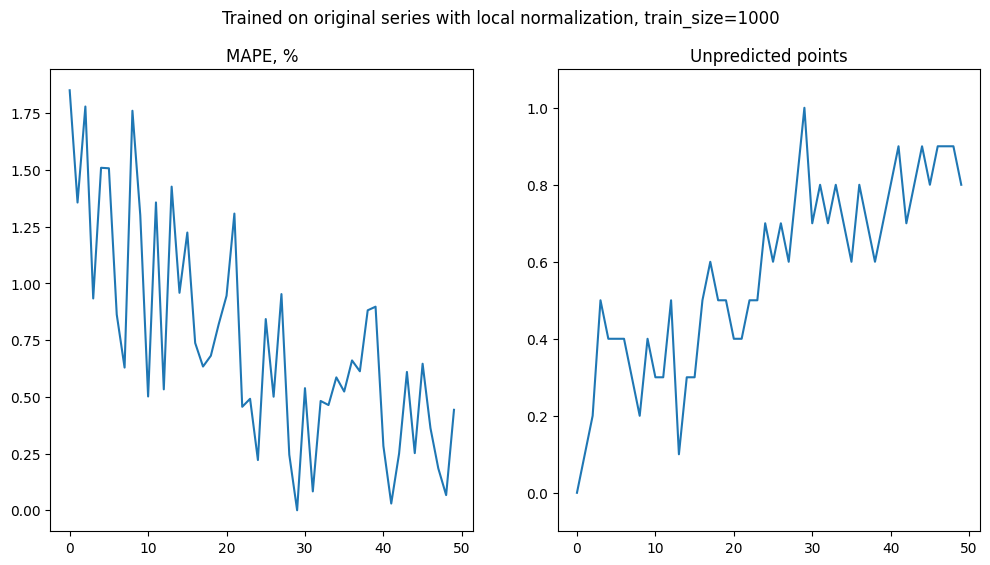

In [51]:
plots(train_points_number, data17[2], data17[3])

In [52]:
print(np.mean(data17[3]))

0.57


Mixing 18

In [ ]:
mat18 = np.array([
    [0.99, 0.99, 1.02],
    [1.01, 0.99, 1.],
    [0.99, 1., 1.],
    [1., 1.01, 1.]
])
data18 = calculate_mixed(train_points_number, begin, mat18 * params)

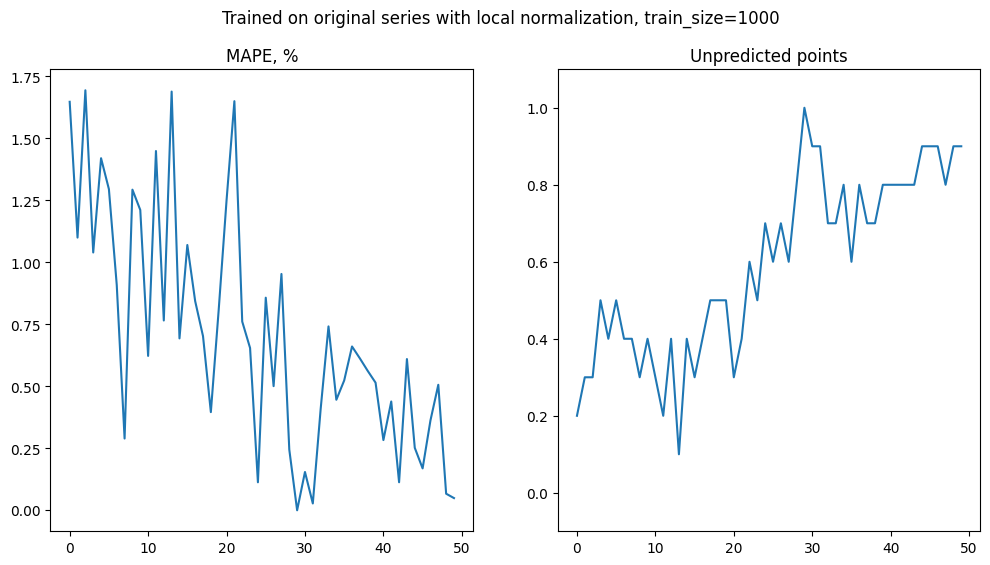

In [54]:
plots(train_points_number, data18[2], data18[3])

In [55]:
print(np.mean(data18[3]))

0.592


| Coefficients of mixed series | Average unpredicted points count |
| :-: | :-: |
| - | 0.714 |
| 0.99, 1.0, 1.0 | 0.644 |
| 0.99, 1.0, 1.0 <br> 1.0, 1.01, 1.0 | 0.614 |
| 1.0, 1.01, 1.0 | 0.678 |
| 0.99, 1.0, 1.0 <br> 1.0, 1.01, 1.0 <br> 1.0, 1.0, 0.98 | 0.686 |
| 0.99, 1.0, 1.0 <br> 1.0, 1.01, 1.0 <br> 1.0, 1.0, 0.98 <br> 0.98, 1.01, 0.99 | 0.688 |
| 1.01, 1.01, 1.02 | 0.722 |
| 1.01, 1.02, 1.02 | 0.68 |
| 1.01, 1.01, 1.02 <br> 0.99, 0.99, 1.02 <br> 1.01, 0.99, 1.0 <br> 1.02, 1.01, 0.99 | 0.652 |
| 1.0, 0.99, 1.0 <br> 0.98, 1.0, 1.0 <br> 1.02, 1.02, 1.01 <br> 1.01, 1.02, 1.02 | 0.706 |
| 0.99, 0.99, 1.02 | 0.61 |
| 1.01, 0.99, 1.0 | 0.646 |
| 1.02, 1.02, 0.99 | 0.67 |
| 0.99, 1.0, 0.98 | 0.722 |
| 0.99, 0.99, 1.02 <br> 1.01, 0.99, 1.0 | 0.618 |
| 0.99, 0.99, 1.02 <br> 1.01, 0.99, 1.0 <br> 0.99, 1.0, 1.0 | 0.556 |
| 0.99, 0.99, 1.02 <br> 1.01, 0.99, 1.0 <br> 1.01, 1.01, 1.02 | 0.635 |
| 0.99, 0.99, 1.02 <br> 1.01, 0.99, 1.0 <br> 0.99, 1.0, 1.0 <br> 1.02, 1.01, 0.99 | 0.57 |
| 0.99, 0.99, 1.02 <br> 1.01, 0.99, 1.0 <br> 0.99, 1.0, 1.0 <br> 1.0, 1.01, 1.0 | 0.592 |